# Training first NN


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jonathandinu/youtube/blob/main/notebooks/training-first-nn.ipynb) [![YouTube Video Views](https://img.shields.io/youtube/views/nVbsl9Phg34)](https://youtu.be/nVbsl9Phg34) [![GitHub Repo stars](https://img.shields.io/github/stars/jonathandinu/youtube?style=social)](https://github.com/jonathandinu/youtube)
> Colab for interactive execution in your browser (no setup) and repository for notebook index and additional resources (slides, etc.)


## References and Resources

* PyTorch Quickstart: https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
* Deep Learning with PyTorch: A 60 Minute Blitz (Training): https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* FashionMNIST Dataset: https://github.com/zalandoresearch/fashion-mnist)
* PyTorch FashionMNIST wrapper: https://pytorch.org/vision/0.18/generated/torchvision.datasets.FashionMNIST.html)
* PyTorch Docs for `torchvision.datasets` https://docs.pytorch.org/vision/main/datasets.html

In [ ]:
# install dependencies for cloud notebook environments, i.e. Google Colab
# %pip install -U diffusers torch torchvision matplotlib

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import v2
from diffusers import utils
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

# default device boilerplate
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
fmnist = tv.datasets.FashionMNIST(
    "./data", train=True, download=True, transform=tv.transforms.ToTensor()
)

test_data = tv.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=tv.transforms.ToTensor(),
)

In [9]:
print(fmnist.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


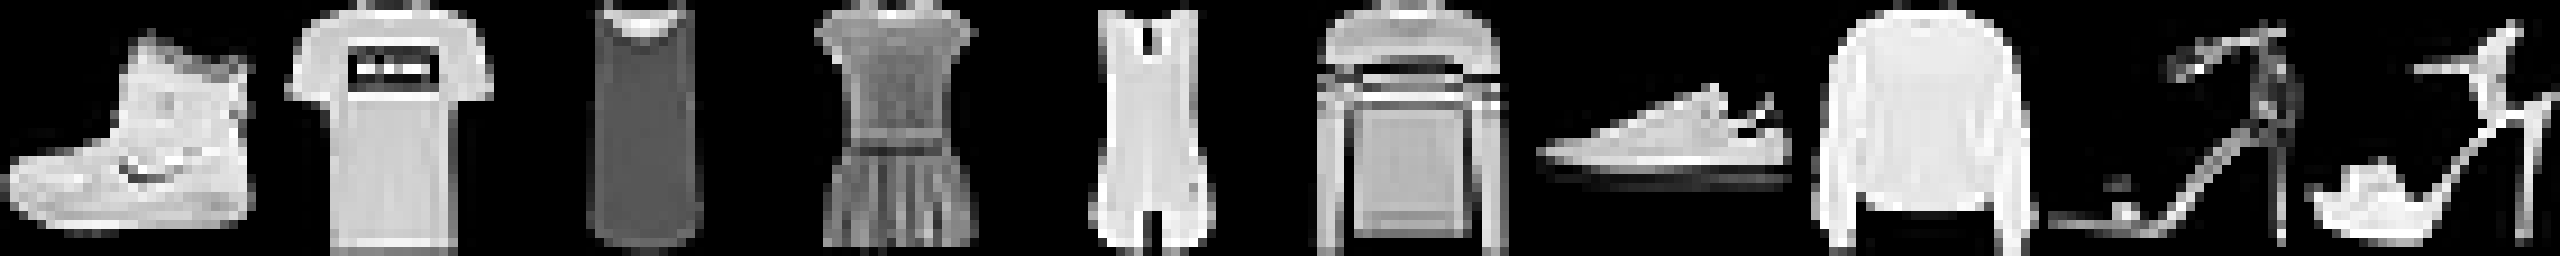

In [11]:
batch = 10
imshow_size = 256

grid = v2.functional.resize(fmnist.data[:batch], imshow_size, interpolation=v2.InterpolationMode.NEAREST)
utils.make_image_grid([Image.fromarray(img) for img in grid.numpy()], 1, 10)

In [12]:
fmnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    return self.layers(x)

MLP()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [17]:
import torch.optim as optim

net = MLP()
net.to(device)

loss_fn = nn.CrossEntropyLoss()

# use PyTorch's built-in minibatch SGD with momentum
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
batch_size = 64

# turn dataset into an iterable DataLoader for training loop
loader = torch.utils.data.DataLoader(
    fmnist, batch_size=batch_size, shuffle=True, generator=torch.Generator()
)

for epoch in range(5):
    running_loss = 0.0

    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("We done!")

[0,   100] loss: 2.288
[0,   200] loss: 2.243
[0,   300] loss: 2.153
[0,   400] loss: 1.956
[0,   500] loss: 1.615
[0,   600] loss: 1.315
[0,   700] loss: 1.131
[0,   800] loss: 1.008
[0,   900] loss: 0.942
[1,   100] loss: 0.854
[1,   200] loss: 0.809
[1,   300] loss: 0.803
[1,   400] loss: 0.778
[1,   500] loss: 0.747
[1,   600] loss: 0.717
[1,   700] loss: 0.696
[1,   800] loss: 0.667
[1,   900] loss: 0.657
[2,   100] loss: 0.658
[2,   200] loss: 0.648
[2,   300] loss: 0.639
[2,   400] loss: 0.611
[2,   500] loss: 0.610
[2,   600] loss: 0.598
[2,   700] loss: 0.593
[2,   800] loss: 0.576
[2,   900] loss: 0.564
[3,   100] loss: 0.552
[3,   200] loss: 0.569
[3,   300] loss: 0.555
[3,   400] loss: 0.535
[3,   500] loss: 0.522
[3,   600] loss: 0.529
[3,   700] loss: 0.538
[3,   800] loss: 0.535
[3,   900] loss: 0.524
[4,   100] loss: 0.524
[4,   200] loss: 0.511
[4,   300] loss: 0.507
[4,   400] loss: 0.504
[4,   500] loss: 0.511
[4,   600] loss: 0.501
[4,   700] loss: 0.492
[4,   800] 

In [18]:
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator()
)

In [21]:
net.eval()

test_loss, correct = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        test_loss += loss_fn(outputs, labels).item()
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
test_loss /= len(test_loader)
correct /= len(test_loader.dataset)

print(f"Test Error\tAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error	Accuracy: 81.6%, Avg loss: 0.508187 



## Appendix

In [2]:
# version of Python of the current Jupyter kernel
import sys, datetime

print(f"Current notebook Python version: {sys.version}")
print(f"Notebook last executed: {datetime.datetime.now()}\n")

# package versions when this notebook was last run in Colab (and committed)
!pip freeze

Current notebook Python version: 3.12.8 (main, Jan 14 2025, 22:49:14) [Clang 19.1.6 ]
Notebook last executed: 2025-05-27 19:34:33.094354

aiohttp==3.8.3
aiosignal==1.3.1
annotated-types==0.7.0
anyio==4.9.0
asgiref==3.5.2
asttokens==3.0.0
async-generator==1.10
async-timeout==4.0.2
attrs==22.2.0
Automat==20.2.0
Babel==2.8.0
bcrypt==3.2.0
blinker==1.4
boto==2.49.0
botocore==1.29.43
certifi==2021.10.8
chardet==4.0.0
charset-normalizer==2.0.12
click==8.1.8
cloud-init==24.3.1
colorama==0.4.4
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.3.1
cryptography==3.4.8
cycler==0.11.0
dbus-python==1.2.18
decorator==5.1.1
distro==1.7.0
distro-info==1.1+ubuntu0.2
dj-database-url==0.5.0
Django==2.2
django-cors-headers==2.5.3
django-storages-redux==1.3.3
dnspython==2.7.0
email_validator==2.2.0
exceptiongroup==1.1.0
executing==2.2.0
fastapi==0.115.12
fastapi-cli==0.0.7
fonttools==4.56.0
frozenlist==1.3.3
gensim==3.8.0
git-filter-repo==2.34.0
gunicorn==20.1.0
gyp==0.1
h11==0.16.0
h